In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pickle

In [2]:
df = pd.read_csv('Absenteeism_preprocessed.csv')
df.head()

,Reason1,Reason2,Reason3,Reason4,Month,Day,Transportation_Expense,Distance,Age,Workload,Hit_Target,Disciplinary_Failure,Education,Son,Social_Drinker,Social_Smoker,Pet,BMI,Absenteeism
0,0,0,0,1,7,3,289,36,33,239554,97,0,0,2,1,0,1,30,4
1,0,0,0,0,7,3,118,13,50,239554,97,1,0,1,1,0,0,31,0
2,0,0,0,1,7,4,179,51,38,239554,97,0,0,0,1,0,0,31,2
3,1,0,0,0,7,5,279,5,39,239554,97,0,0,2,1,1,0,24,4
4,0,0,0,1,7,5,289,36,33,239554,97,0,0,2,1,0,1,30,2


#### Creating target into a binary variable for classification using median value of absenteeism.

In [3]:
sorted(df['Absenteeism'].unique())

[0, 1, 2, 3, 4, 5, 7, 8, 16, 24, 32, 40, 48, 56, 64, 80, 104, 112, 120]

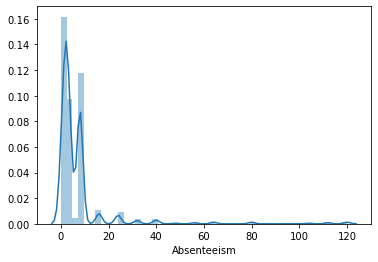

In [4]:
sns.distplot(df['Absenteeism'])
plt.show()

In [5]:
df['Absenteeism'].median()

3.0

##### <= 3 hours --> Moderately Absent
##### > 3 hours --> Excessively Absent

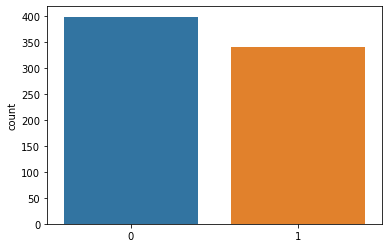

0.4599728629579376

In [6]:
targets = np.where(df['Absenteeism'] > df['Absenteeism'].median(), 1, 0)
sns.countplot(targets)
plt.show()
targets.sum()/targets.shape[0]

##### Using Median is numerically stable and rigid as it is not affected by outliers and balances the data, 45% of the targets are 1s

In [7]:
df['Excessive_Absenteeism'] = targets

In [8]:
df = df.drop('Absenteeism', 1)
df.head()

,Reason1,Reason2,Reason3,Reason4,Month,Day,Transportation_Expense,Distance,Age,Workload,Hit_Target,Disciplinary_Failure,Education,Son,Social_Drinker,Social_Smoker,Pet,BMI,Excessive_Absenteeism
0,0,0,0,1,7,3,289,36,33,239554,97,0,0,2,1,0,1,30,1
1,0,0,0,0,7,3,118,13,50,239554,97,1,0,1,1,0,0,31,0
2,0,0,0,1,7,4,179,51,38,239554,97,0,0,0,1,0,0,31,0
3,1,0,0,0,7,5,279,5,39,239554,97,0,0,2,1,1,0,24,1
4,0,0,0,1,7,5,289,36,33,239554,97,0,0,2,1,0,1,30,0


#### Splitting Data

In [9]:
X = df.iloc[:, :-1]
y = df['Excessive_Absenteeism']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 20, stratify = y)
X_train.shape, X_test.shape

((589, 18), (148, 18))

In [10]:
y_train.value_counts(1), y_test.value_counts(1)

(0    0.539898
 1    0.460102
 Name: Excessive_Absenteeism, dtype: float64,
 0    0.540541
 1    0.459459
 Name: Excessive_Absenteeism, dtype: float64)

#### Scaling

In [11]:
X_train.columns

Index(['Reason1', 'Reason2', 'Reason3', 'Reason4', 'Month', 'Day',
       'Transportation_Expense', 'Distance', 'Age', 'Workload ', 'Hit_Target',
       'Disciplinary_Failure', 'Education', 'Son', 'Social_Drinker',
       'Social_Smoker', 'Pet', 'BMI'],
      dtype='object')

In [12]:
cols_scale = ['Month', 'Day', 'Transportation_Expense', 'Distance', 'Age', 'Workload ', 'Hit_Target', 'Son', 'Pet', 'BMI']
cols_dummy = ['Reason1', 'Reason2', 'Reason3', 'Reason4', 'Disciplinary_Failure', 'Education', 'Social_Drinker','Social_Smoker']

In [13]:
ss = StandardScaler()
X_train_scale = pd.DataFrame(ss.fit_transform(X_train[cols_scale]), columns = cols_scale)
X_train = pd.concat([X_train_scale, X_train[cols_dummy].reset_index(drop = True)], axis = 1)[X_train.columns]
X_train.shape

(589, 18)

In [15]:
X_test_scale = pd.DataFrame(ss.transform(X_test[cols_scale]), columns = cols_scale)
X_test = pd.concat([X_test_scale, X_test[cols_dummy].reset_index(drop = True)], axis = 1)[X_test.columns]
X_test.shape

(148, 18)

In [16]:
X_test.isna().sum().sum()

0

#### Logistic Regression

In [17]:
lr = LogisticRegression(random_state = 20, n_jobs = -1)
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7589134125636672

##### Coefficients and Intercept

In [18]:
lr.intercept_

array([-0.63277404])

In [19]:
lr.coef_

array([[ 1.36750556,  0.25895511,  1.63667105, -0.41918108,  0.10968958,
        -0.19167576,  0.46694929, -0.16570712, -0.13036306, -0.03065993,
        -0.05409111, -2.8412235 ,  0.01679679,  0.40878522,  0.6025038 ,
         0.00380296, -0.13072886,  0.13486428]])

In [20]:
feature_names = X_train.columns.values
feature_names

array(['Reason1', 'Reason2', 'Reason3', 'Reason4', 'Month', 'Day',
       'Transportation_Expense', 'Distance', 'Age', 'Workload ',
       'Hit_Target', 'Disciplinary_Failure', 'Education', 'Son',
       'Social_Drinker', 'Social_Smoker', 'Pet', 'BMI'], dtype=object)

In [21]:
summary_table = pd.DataFrame({'Feature Name' : feature_names})
summary_table['Coefficients'] = lr.coef_.T
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', lr.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature Name,Coefficients
0,Intercept,-0.632774
1,Reason1,1.367506
2,Reason2,0.258955
3,Reason3,1.636671
4,Reason4,-0.419181
5,Month,0.109690
6,Day,-0.191676
7,Transportation_Expense,0.466949
8,Distance,-0.165707
9,Age,-0.130363


##### Interpretating the coefficients

In [22]:
summary_table['odds_ratio'] = np.exp(summary_table['Coefficients'])
summary_table.sort_values('odds_ratio', ascending = False)

,Feature Name,Coefficients,odds_ratio
3,Reason3,1.636671,5.138037
1,Reason1,1.367506,3.925546
15,Social_Drinker,0.602504,1.826687
7,Transportation_Expense,0.466949,1.595121
14,Son,0.408785,1.504988
2,Reason2,0.258955,1.295576
18,BMI,0.134864,1.144381
5,Month,0.109690,1.115932
13,Education,0.016797,1.016939
16,Social_Smoker,0.003803,1.003810


- If the person has cited reason type 3 or reason type 1, his odds of excessive absenteeism increase by 5 and 4 times respectively.
- If a person is a social drinker, his odds of excessive absenteeism increase by 1.8 times.
- If the transportation expenses of a person increases by 1 standard deviation unit, his odds of excessive absenteeism increase by 1.5 times.
- If a person has more number of children, his odds of excessive absenteeism increase by 1.5 times.
- If the person has cited reason type 2, his odds of excessive absenteeism increase by 1.2 times.
- If the BMI of a person increases by 1 standard deviation unit, his odds of excessive absenteeism increase by 1.1 units.

##### Testing the model

In [23]:
def eval(model, X, y):
    pred = model.predict(X)
    prob = model.predict_proba(X)[:, 1]
    print(metrics.classification_report(y, pred))
    metrics.plot_confusion_matrix(model, X, y)
    metrics.plot_roc_curve(model, X, y)
    plt.show()

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        80
           1       0.74      0.78      0.76        68

    accuracy                           0.77       148
   macro avg       0.77      0.77      0.77       148
weighted avg       0.77      0.77      0.77       148



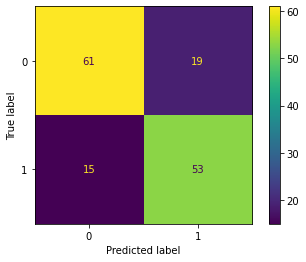

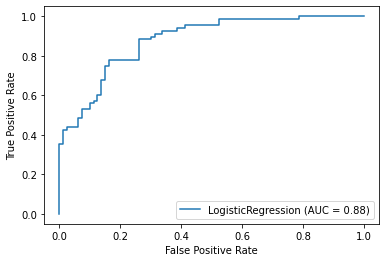

In [24]:
eval(lr, X_test, y_test)

#### Random Forest

In [25]:
X = df.iloc[:, :-1]
y = df['Excessive_Absenteeism']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 20, stratify = y)
X_train.shape, X_test.shape

((589, 18), (148, 18))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       318
           1       0.98      0.97      0.97       271

    accuracy                           0.97       589
   macro avg       0.97      0.97      0.97       589
weighted avg       0.97      0.97      0.97       589



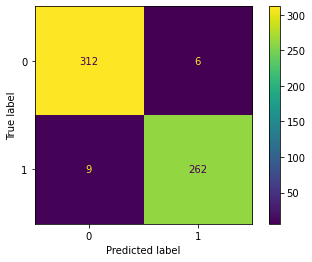

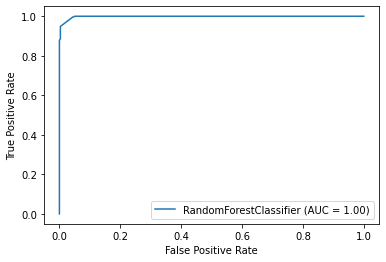

In [26]:
rf = RandomForestClassifier(random_state = 20, n_jobs = -1)
rf.fit(X_train, y_train)
eval(rf, X_train, y_train)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        80
           1       0.77      0.79      0.78        68

    accuracy                           0.80       148
   macro avg       0.80      0.80      0.80       148
weighted avg       0.80      0.80      0.80       148



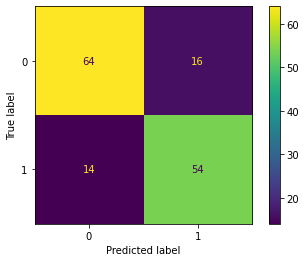

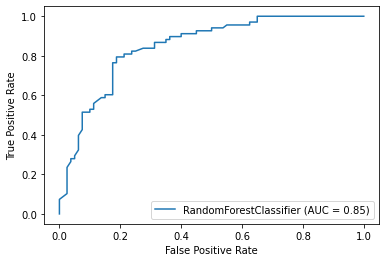

In [27]:
eval(rf, X_test, y_test)

##### Tuning Random Forest

In [28]:
rf = RandomForestClassifier(random_state = 20, n_jobs = -1)
params = {'max_features' : np.arange(1, X_train.shape[1]),
         'n_estimators' : np.arange(50, 500),
         'min_samples_leaf' : np.arange(25, 50),
         'max_depth' : np.arange(2, 25),
         'min_samples_split' : np.arange(25, 50)}
rsearch = RandomizedSearchCV(rf, params, n_jobs = -1, scoring = 'f1', random_state = 20, cv = 10, n_iter = 100, verbose = 2)
rsearch.fit(X_train, y_train)
rsearch.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.0min finished


{'n_estimators': 410,
 'min_samples_split': 48,
 'min_samples_leaf': 30,
 'max_features': 15,
 'max_depth': 8}

In [29]:
rsearch.best_score_

0.6992750542795915

##### Tuned Random Forest

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       318
           1       0.71      0.73      0.72       271

    accuracy                           0.74       589
   macro avg       0.74      0.74      0.74       589
weighted avg       0.74      0.74      0.74       589



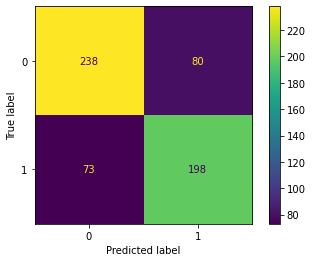

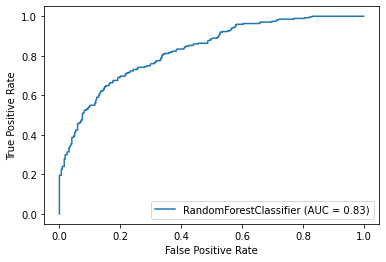

              precision    recall  f1-score   support

           0       0.85      0.75      0.79        80
           1       0.74      0.84      0.79        68

    accuracy                           0.79       148
   macro avg       0.79      0.79      0.79       148
weighted avg       0.80      0.79      0.79       148



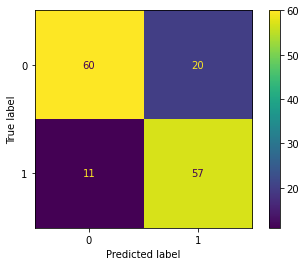

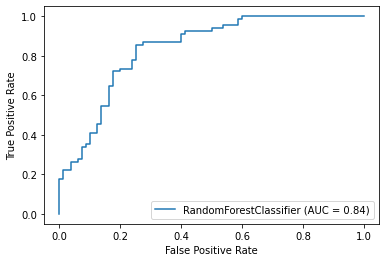

In [30]:
rf = rsearch.best_estimator_
rf.fit(X_train, y_train)
eval(rf, X_train, y_train)
eval(rf, X_test, y_test)

In [32]:
X_test.to_csv('Test_Data.csv', index = False)

#### Saving the model

In [31]:
with open('model', 'wb') as file:
    pickle.dump(rf, file)